In [94]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import random
import pandas as pd
import seaborn as sb

At 0K we have a real (choose positive) 1D function in a spatially varying 1D potential of the form

H = alpha(z) (Psi)^2 + c(z) (d \Psi) ^2 + u(z)/2 \Psi^4

With spatially varying coefficients u(z), c(z) ~ circumference = 2 pi r(a) (1+ a sin(kz))

alpha(z) = (alpha_0 + c |i n A_th|^2) \* circumference
     = (alpha_0 + c n^2 R'(z)/ R(z) ) \* 2 pi r(a) (1 + a sin kz)

   = alpha_0 2 pi r(a)(1+a sin kz ) + c_0 n^2 2 pi r(a) (1+a sin kz) ( k r a cos(kz) )^2/ (1+ a^2 k^2 r(a)^2 cos^2 kz)

With radius rescaled r(a) = 1 / sqrt(q - a^2/2)

Quantities radius_rescaled r(a) = r_0 / sqrt(1+a^2/2)

A_theta A_th = k r a cos(kz) / sqrt_g_zz

g_z= (1+a^2 k^2 a(r)^2 cos^2 kz) and sqrt_g_z

and sqrt_g_th = r(a) (1+a sin kz)

can be retrieved from system_cylinder

In [26]:
import surfaces_and_fields.system_cylinder as system_cylinder

In [27]:
#the cylinder object holds k, r0
def alpha_z_index_raise(alpha0, c0, n, a, z, cylinder):
    return (alpha0 + c0 * n**2 * cylinder.A_theta(amplitude=a,z=z)**2 #A th and grad parts incl a factor of eta_thth, 
           /cylinder.g_theta(amplitude=a, z=z)
           )#*2*math.pi*cylinder.sqrt_g_theta(amplitude=1, z=z)        #index raise in cylidrical coordinates
                                                                      #the factor is 1/gthth


def alpha_z(alpha0, c0, n, a, z, cylinder):
    return (alpha0 + c0 * n**2 * cylinder.A_theta(amplitude=a,z=z)**2 
           )#*2*math.pi*cylinder.sqrt_g_theta(amplitude=1, z=z)        #
           #this factor of circumfrence always cancels locally

In [28]:
def c_z_index_raise(c0, a, z, cylinder):
    return c0*2*math.pi/cylinder.sqrt_g_theta(amplitude=a, z=z) #combinging *sqrt_g_th with 1/g_th for index raise,
                                                                # we have 1/sqrt_g_th
def c_z(c0, a, z, cylinder):
    return c0/ cylinder.g_z(amplitude=a, z=z) #two factors of 1/sqrt_g_z in the gradient.  A_th^2 has them too.  
                                              # it's for changing distance in gradient = diff / diff x . 
                                              # in general
                                              # since gradient energy is also weighted by line segment length 1x (in 1D),
                                              # this combines to 1/sqrt_g_z
                                              # but here we cancelled that factor of sqrt_g on u,alpha, and c
                                              # along with circumference

def u_z(u0, a, z, cylinder):
    return u0#*2*math.pi*cylinder.sqrt_g_theta(amplitude=1, z=z)

next we need to find, for each k and a, the solution Psi that is minimized in this potential

Equation of motion / variational derivative is

0 = d H / dPsi - d_z (d H / d dPsi )

= 2 alpha(z) Psi + 2 u(z) Psi^3 - 2 dz (c(z) dPsi)

wave equation

alpha(z) Psi + u(z) Psi^3 = c(z) dzz Psi

In [37]:
def get_local_energy(alpha_zs, u0, z_index, value, z_space):
    return (alpha_zs[z_index]*value**2 + u0/2 * value**4)*z_space

In [178]:
def get_grad_energy(c_zs, z_index, z_space, value1, value2):
    gradient = (value1-value2)/(2*z_space)
    return (c_zs[z_index]*gradient**2)*z_space 

In [164]:
def minimize(zs, alpha_zs, c_zs, n,u0, initial, initial_step, n_steps):
    l=len(zs)
    z_len = zs[1]-zs[0]
    step=initial_step
    arr=initial
    energy=[get_local_energy(alpha_zs, u0, n, value, z_len) for n,value in enumerate(initial)]
    #print(zs, arr)
    grad_energy=[get_grad_energy(c_zs,n, z_len, arr[n-1], arr[n+1]) for n, value in enumerate(initial[:-1])]
    grad_energy.append(get_grad_energy(c_zs,n, z_len, arr[l-1], arr[0]))
    for i in range(n_steps):
        for j in range(l):
            loc = random.choice(range(l))
            new_value = random.gauss(arr[loc], step)
            new_local_energy = get_local_energy(alpha_zs, u0, loc,new_value, z_len)
            new_left_derivative_energy = get_grad_energy(c_zs,loc, z_len, arr[loc-2],new_value)
            try:
                new_right_derivative_energy = get_grad_energy(c_zs,loc, z_len, new_value, arr[loc+2])
            except IndexError:
                new_right_derivative_energy = get_grad_energy(c_zs,loc, z_len, new_value, arr[loc+2-l])
            try:
                energy_diff = (energy[loc]+grad_energy[loc-1]+grad_energy[loc+1])-(new_local_energy+new_left_derivative_energy+new_right_derivative_energy)
            except IndexError:
                energy_diff = (energy[loc]+grad_energy[loc-1]+grad_energy[loc+1-l])-(new_local_energy+new_left_derivative_energy+new_right_derivative_energy)
            if energy_diff >= 0:
                energy[loc]= new_local_energy
                grad_energy[loc-1] = new_left_derivative_energy
                try:
                    grad_energy[loc+1] = new_right_derivative_energy
                except IndexError:
                    grad_energy[loc+1-l] = new_right_derivative_energy
                arr[loc]=new_value

        #print(sum(energy), sum(grad_energy), sum(energy)+ sum(grad_energy), step)
    return (arr, energy, grad_energy, step)

In [293]:
k=1
alpha0=-1
c0=.1
n=6
u0=1
a=.5
z_space=.1
cylinder = system_cylinder.Cylinder(wavenumber=k, radius=1, kappa=0)
zs = np.arange(0, 2*math.pi, z_space)
alpha_zs= [alpha_z_index_raise(alpha0, c0, n, a, z, cylinder) for z in zs]
c_zs= [c_z(c0, a, z, cylinder) for z in zs]
u_zs= [u_z(u0, a, z, cylinder) for z in zs]
arr, energy, grad_energy, step = minimize(zs, arr, .5, 10000)

TypeError: minimize() missing 3 required positional arguments: 'initial', 'initial_step', and 'n_steps'

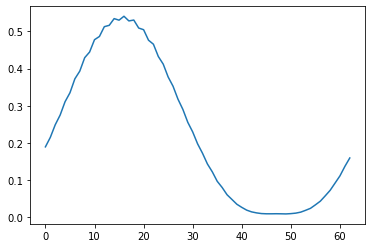

In [279]:
plt.plot(arr)

In [158]:
min_energy=9999999
energys=[]
minimizing_profile=[]
minimizing_a=None
a_s=np.arange(0,1,.1)
for a in a_s:
    print(a)
    cylinder = system_cylinder.Cylinder(wavenumber=k, radius=1, kappa=0)
    zs = np.arange(0, 2*math.pi/k, z_space)
    alpha_zs= [alpha_z_index_raise(alpha0, c0, n, a, z, cylinder) for z in zs]
    c_zs= [c_z(c0, a, z, cylinder) for z in zs]
    arr, energy, grad_energy, step = minimize( zs,alpha_zs, c_zs, u0,[abs(alpha0)*.5 for z in zs], .1, 5000)
    energy=sum(energy)+sum(grad_energy)
    if energy <= min_energy:
        minimizing_profile=arr
        min_energy=energy
        minimizing_a=a
    energys.append(energy)
    plt.plot(arr, label="a="+str(round(a,3)))
print(minimizing_a, min_energy, minimizing_profile)
plt.legend()

0.0


NameError: name 'z_space' is not defined

Text(0, 0.5, '0K field energy')

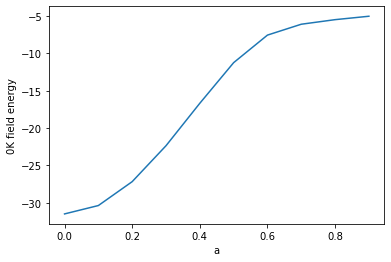

In [260]:
plt.plot(a_s, energys)
plt.xlabel("a")
plt.ylabel("0K field energy")

0.0 -3.1490185956266377


(0.0, 1.5)

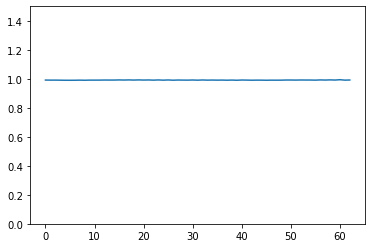

In [275]:
print(minimizing_a, min_energy)
plt.plot(minimizing_profile)
plt.ylim((0,1.5))

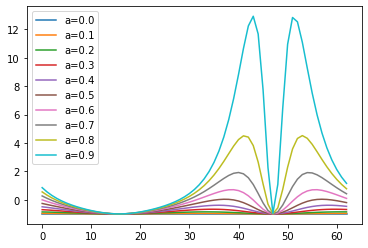

In [262]:
for a in a_s:
    cylinder = system_cylinder.Cylinder(wavenumber=k, radius=1, kappa=0)
    zs = np.arange(0, 2*math.pi/k, z_space)
    alpha_zs= [alpha_z_index_raise(alpha0, c0, n, a, z, cylinder) for z in zs]
    plt.plot(alpha_zs, label="a="+str(round(a,3)))
plt.legend()

In [199]:
def field_energy(a, k, alpha0, c0, n, u0, z_space=.1, radius=1, n_steps=5000, stepsize=.1, initial=None):
    cylinder = system_cylinder.Cylinder(wavenumber=k, radius=radius, kappa=0)
    zs = np.arange(0, 2*math.pi/k, z_space)
    if initial is None:
        initial=[abs(alpha0)*.5 for z in zs]
    alpha_zs= [alpha_z_index_raise(alpha0, c0, n, a, z, cylinder) for z in zs]
    c_zs= [c_z( c0, a, z, cylinder) for z in zs]
    alpha_curv_energys_zs = [alpha-alpha0 for alpha in alpha_zs]
    arr, energy, grad_energy, curv_energy = minimize(zs, alpha_zs, c_zs, n,u0, 
                                                     initial, stepsize, n_steps)
    energy=sum(energy)+sum(grad_energy)
    curv_energy=sum([alpha_Ai_part*arr[n]**2 for n, alpha_Ai_part in enumerate(alpha_curv_energys_zs)] )
    print(a,energy)
    return energy, curv_energy, arr

0.0 0.1 -3.1499998316309803 0.0
0.1 0.1 -3.037737715941289 1.108164631729585
0.2 0.1 -2.717646845017543 4.092029694749636
0.30000000000000004 0.1 -2.236528112060962 7.961024838864491
0.4 0.1 -1.668708417242229 11.062892415919446
0.5 0.1 -1.1295758061551964 11.071023617605706
0.6000000000000001 0.1 -0.7706649943775329 7.580746686835871
0.7000000000000001 0.1 -0.6298691581605554 4.635901137700458
0.8 0.1 -0.5757614109986914 4.189624401081655
0.9 0.1 -0.534671190895607 3.896320073693762


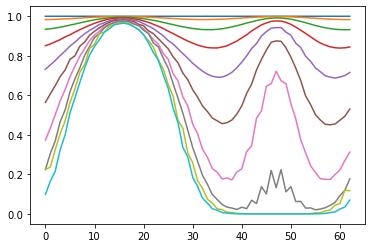

0.0 0.2 -3.1499981156643417 0.0
0.1 0.2 -2.928129650316063 2.164787855267061
0.2 0.2 -2.327345774570969 7.3687474208999175
0.30000000000000004 0.2 -1.5324707290607922 12.021322554830451
0.4 0.2 -0.8225873204969173 11.694696816283757
0.5 0.2 -0.44205112642357985 7.178334122410978
0.6000000000000001 0.2 -0.3425234059307557 4.363989819390632
0.7000000000000001 0.2 -0.28926678613783874 3.6838320635241724
0.8 0.2 -0.24643005311109878 3.7627290840505174
0.9 0.2 -0.2178813832206817 3.5458809671782507


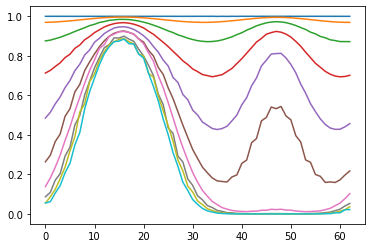

0.0 0.30000000000000004 -3.1499944747841253 0.0
0.1 0.30000000000000004 -2.8209314383257347 3.174742008373179
0.2 0.30000000000000004 -1.9741298148309296 9.959511535048186
0.30000000000000004 0.30000000000000004 -0.9980363968744973 13.46310814845322
0.4 0.30000000000000004 -0.3738535030114984 8.83143152794448
0.5 0.30000000000000004 -0.20790116861190264 4.24571566252413
0.6000000000000001 0.30000000000000004 -0.1347211851377899 3.9142225710709595
0.7000000000000001 0.30000000000000004 -0.10033479931793307 3.2316642448683726
0.8 0.30000000000000004 -0.06699187894022751 3.332749825814186
0.9 0.30000000000000004 -0.04734000255003862 3.075786643561878


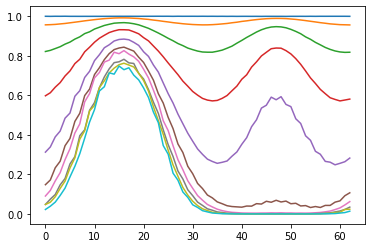

0.0 0.4 -3.1499803939269704 0.0
0.1 0.4 -2.7159931025451187 4.142130772367215
0.2 0.4 -1.654718348561061 11.938058468213699
0.30000000000000004 0.4 -0.6024940095424014 12.976564527132895
0.4 0.4 -0.15579925151948365 5.801970830067558
0.5 0.4 -0.058314070822755026 3.824224836472066
0.6000000000000001 0.4 -0.02597923228302182 2.734495011231832
0.7000000000000001 0.4 0.0064391604607945685 2.6511722018911477
0.8 0.4 0.020790374812150098 2.271455515002874
0.9 0.4 0.014164467700968353 1.4923489074773695


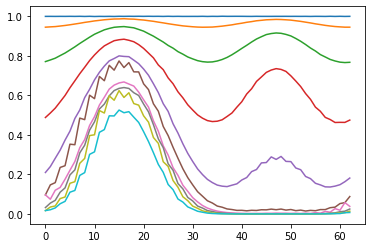

0.0 0.5 -3.1499435374415397 0.0
0.1 0.5 -2.6132055877708975 5.074795654666252
0.2 0.5 -1.3667923477769057 13.407942627730918
0.30000000000000004 0.5 -0.32146589136653425 11.413239007377943
0.4 0.5 -0.042228281023139275 4.108671216515637
0.5 0.5 0.007021054894415346 2.4665415411432257
0.6000000000000001 0.5 0.02871718821370009 1.8431705270166592
0.7000000000000001 0.5 0.03840650077245028 1.4990939070831122
0.8 0.5 0.02295781156371743 0.7957911597774258
0.9 0.5 0.017536704920504752 0.5215951950998865


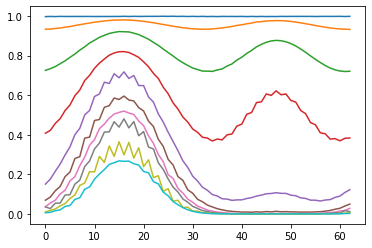

0.0 0.6 -3.1498486609441394 0.0
0.1 0.6 -2.512537130360761 5.967751182883089
0.2 0.6 -1.1084172690864356 14.420682279664426
0.30000000000000004 0.6 -0.13537350749353144 9.208337256136074
0.4 0.6 0.013175697480636711 2.677582585207895
0.5 0.6 0.027632479284706274 1.3203080935019988
0.6000000000000001 0.6 0.04339720348954118 1.2110302790212673
0.7000000000000001 0.6 0.006756682386741949 0.14848498951678724
0.8 0.6 0.0019781693232363536 0.03802297222726264
0.9 0.6 0.0007759030136994752 0.01304333356944639


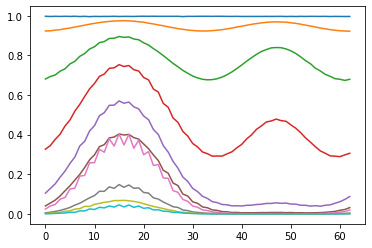

0.0 0.7000000000000001 -1.309643118153549 0.0
0.1 0.7000000000000001 -2.41377445076651 6.688450282190929
0.2 0.7000000000000001 -0.8789104212996092 14.925995268101968
0.30000000000000004 0.7000000000000001 -0.030629653164676446 6.480441983537393
0.4 0.7000000000000001 0.03195953904961091 1.5980565536169598
0.5 0.7000000000000001 0.015836040395270208 0.42328237654537737
0.6000000000000001 0.7000000000000001 0.003304366305515472 0.06213837975064431
0.7000000000000001 0.7000000000000001 0.0007659641719431677 0.012231771847551432
0.8 0.7000000000000001 0.0002759309399907884 0.0035508810488286352
0.9 0.7000000000000001 0.00011280518792495776 0.0015012509895764305


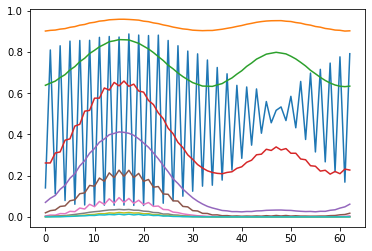

0.0 0.8 -0.00017193053927787338 0.0
0.1 0.8 -0.00024924652062431694 0.0004128574179259512
0.2 0.8 -0.00018463431546894964 0.0017847967111871267
0.30000000000000004 0.8 -2.366699838883703e-05 0.0032813982073875156
0.4 0.8 0.00010135231075389609 0.003363704118663088
0.5 0.8 0.00016785744038858445 0.00319908271429627
0.6000000000000001 0.8 0.00015122294780537245 0.0021473133941696623
0.7000000000000001 0.8 8.261205027725461e-05 0.0010409185689825551
0.8 0.8 5.6995788787241204e-05 0.0006379432878628045
0.9 0.8 2.7755324761507282e-05 0.0003080402926779366


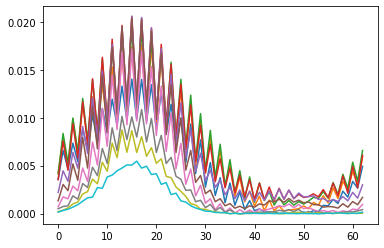

0.0 0.9 -9.33182096616562e-06 0.0
0.1 0.9 -1.1925096190226643e-05 2.6393687031742833e-05
0.2 0.9 -6.530922778239937e-06 9.945612910475006e-05
0.30000000000000004 0.9 2.89821825919168e-06 0.00019717994692435194
0.4 0.9 1.222444946667631e-05 0.0002720535054807676
0.5 0.9 1.7063941694500043e-05 0.00026411147613274454
0.6000000000000001 0.9 1.747650547466609e-05 0.00022684695479704953
0.7000000000000001 0.9 1.5552722035671354e-05 0.00018016253754001517
0.8 0.9 1.3347390134377965e-05 0.00014524739052713574
0.9 0.9 1.0647469940202266e-05 0.00010225400774626621


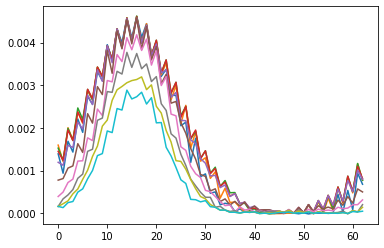

In [46]:
energys={}
curv_energys={}
for c in np.arange(.1, 1, .1):
    energys[c]={}
    curv_energys[c]={}
    plt.close()
    for a in np.arange(0,1,.1):
        if c>=1:
            stepsize=.1/c
        else:
            stepsize=.1
        e, c_e, arr = field_energy(a=a,k=1,alpha0=-1,c0=c,n=6,u0=1, stepsize=stepsize, initial=arr)
        energys[c][a]=e
        curv_energys[c][a]=c_e
        print(a, c, e,c_e)
        plt.plot(arr)
    plt.show()

In [14]:
dfe=pd.DataFrame(energys)
dfe

,0.1


<AxesSubplot:>

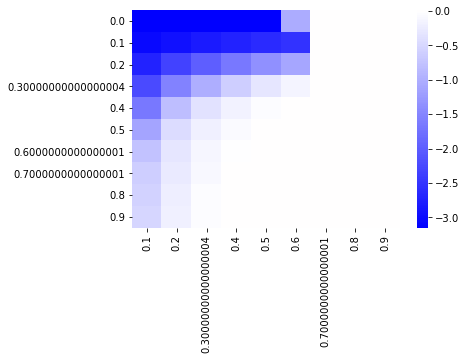

In [345]:
sb.heatmap(dfe, cmap='bwr', center=0)

## Pretty plot of four potentials and minimized field profiles

generate alpha'(z) data

In [67]:
k=1
radius=1
zspace = .05
alpha0=-1
u0=1
zs=np.arange(0,2*math.pi, zspace)
c0s=[.1, 1]
ns=[1,6]
cy = system_cylinder.Cylinder(wavenumber=k, radius=radius, kappa=0)
a_s=np.arange(0,1,.1)
alphas_1 =  dict([(a,[alpha_z_index_raise(alpha0, c0=c0s[0], n=ns[0], a=a, z=z, cylinder=cy) for z in zs]) for a in a_s])
alphas_2 = dict([(a,[alpha_z_index_raise(alpha0, c0=c0s[0], n=ns[1], a=a, z=z, cylinder=cy) for z in zs]) for a in a_s])
alphas_3 = dict([(a,[alpha_z_index_raise(alpha0, c0=c0s[1], n=ns[0], a=a, z=z, cylinder=cy) for z in zs]) for a in a_s])
alphas_4 = dict([(a,[alpha_z_index_raise(alpha0, c0=c0s[1], n=ns[1], a=a, z=z, cylinder=cy) for z in zs]) for a in a_s])

In [117]:
#copper colorscale for potentials
cols_potential = dict(zip(a_s, plt.cm.copper([a for a in a_s])))
#colorscale for field profiles
cols = dict(zip(a_s, plt.cm.winter([a for a in a_s])))

In [200]:
#generate minimizing profiles
field_1 =  dict([(a,field_energy(a, k, alpha0, c0=c0s[0], n=ns[0], u0=u0, z_space=zspace, n_steps=5000, stepsize=.0001, initial=field_1[a])[2]) for a in a_s])
field_2 = dict([(a,field_energy(a, k, alpha0, c0=c0s[0], n=ns[1], u0=u0, z_space=zspace, n_steps=5000, stepsize=.0001, initial=field_2[a])[2]) for a in a_s])
field_3 = dict([(a,field_energy(a, k, alpha0, c0=c0s[1], n=ns[0], u0=u0, z_space=zspace, n_steps=5000, stepsize=.0001, initial=field_3[a])[2]) for a in a_s])
field_4 = dict([(a,field_energy(a, k, alpha0, c0=c0s[1], n=ns[1], u0=u0, z_space=zspace, n_steps=5000, stepsize=.0001, initial=field_4[a])[2]) for a in a_s])

0.0 -3.1499999999993347
0.1 -3.146842435269726
0.2 -3.1373618193999775
0.30000000000000004 -3.1214011796895127
0.4 -3.0982687032854397
0.5 -3.066062154334917
0.6000000000000001 -3.0203646191488147
0.7000000000000001 -2.9509695098183277
0.8 -2.8309475843292047
0.9 -2.562858567354048
0.0 -3.14999999999827
0.1 -3.037739576081531
0.2 -2.717651604516288
0.30000000000000004 -2.23649585008698
0.4 -1.6685749962763854
0.5 -1.12910912076509
0.6000000000000001 -0.7702984034463678
0.7000000000000001 -0.6320885104500548
0.8 -0.5748631330206445
0.9 -0.5331254011857685
0.0 -3.149999999937715
0.1 -3.118505615164912
0.2 -3.0249268478775155
0.30000000000000004 -2.870780007664113
0.4 -2.655190571793515
0.5 -2.3714280043540557
0.6000000000000001 -2.0044787823353425
0.7000000000000001 -1.5354862678442707
0.8 -0.9959450964462705
0.9 -0.6361856151973979
0.0 -3.149999999914575
0.1 -2.130627834326856
0.2 -0.35763612294866653
0.30000000000000004 0.012186745561050379
0.4 4.200729582711159e-06
0.5 8.0968354463122

In [201]:
#save the data
df1=pd.DataFrame(field_1)
df2=pd.DataFrame(field_2)
df3=pd.DataFrame(field_3)
df4=pd.DataFrame(field_4)
#df1.to_csv("field_profile_1.csv")
#df2.to_csv("field_profile_2.csv")
#df3.to_csv("field_profile_3.csv")
#df4.to_csv("field_profile_4.csv")

In [195]:
field_1 =  dict([(a,field_energy(a, k, alpha0, c0=c0s[0], n=ns[0], u0=u0, z_space=zspace, n_steps=5000, stepsize=.01, initial=[(x+y)/2 for x,y in zip(field_1[a],field_1[a][1:]+[field_1[a][0]])])[2]) for a in a_s])
field_2 = dict([(a,field_energy(a, k, alpha0, c0=c0s[0], n=ns[1], u0=u0, z_space=zspace, n_steps=5000, stepsize=.01, initial=[(x+y)/2 for x,y in zip(field_2[a],field_2[a][1:]+[field_2[a][0]])])[2]) for a in a_s])
field_3 = dict([(a,field_energy(a, k, alpha0, c0=c0s[1], n=ns[0], u0=u0, z_space=zspace, n_steps=5000, stepsize=.01, initial=[(x+y)/2 for x,y in zip(field_3[a],field_3[a][1:]+[field_3[a][0]])])[2]) for a in a_s])
field_4 = dict([(a,field_energy(a, k, alpha0, c0=c0s[1], n=ns[1], u0=u0, z_space=zspace, n_steps=5000, stepsize=.01, initial=[(x+y)/2 for x,y in zip(field_4[a],field_4[a][1:]+[field_4[a][0]])])[2]) for a in a_s])

-3.1499999999916595
-3.1468424351459636
-3.137361816425111
-3.1214011686813605
-3.098268681885838
-3.0660621254913543
-3.0203645195748408
-2.9509695956448136
-2.830947585927129
-2.562861828426313
-3.1499999999934007
-3.0377395086558527
-2.717650615346148
-2.2364944686358683
-1.6685763154258568
-1.1290593448227146
-0.7702659273487231
-0.6320292505560188
-0.5746661915821654
-0.5332713826453752
-3.1499999998658024
-3.1185055645111803
-3.0249267553773556
-2.870778474733876
-2.655184822091939
-2.371405239597774
-2.004446819934332
-1.5354486237716771
-0.9960806619361928
-0.6367451855926745
-3.1499999998388097
-2.130627540808199
-0.35758288707331803
0.01236042182357369
8.268044323485832e-05
1.7565534483911946e-07
8.351894283641594e-08
8.309790479140488e-09
1.9279931116747504e-06
4.1963880540578716e-08


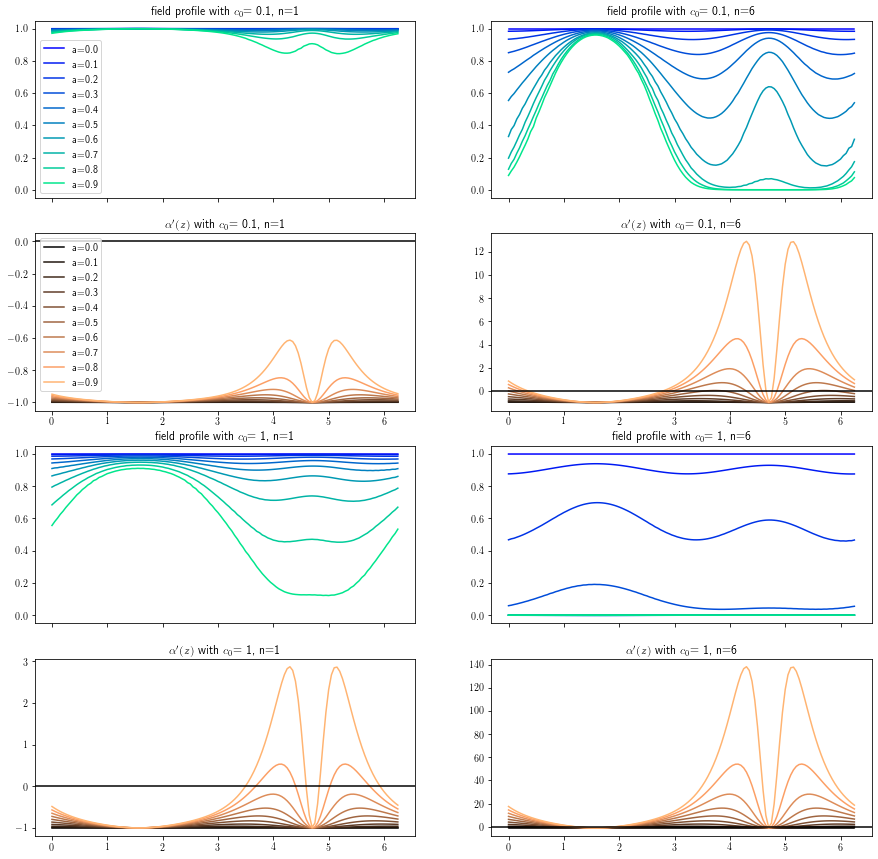

In [212]:
fig, axs = plt.subplots(4, 2, figsize=(15,15))
#potentials
for a in alphas_1:
    axs[0,0].plot(zs, field_1[a], color=cols[a], label = "a="+str(round(a,3)))
    axs[1,0].plot(zs, alphas_1[a], color=cols_potential[a], label = "a="+str(round(a,3)))
    axs[0,1].plot(zs, field_2[a], color=cols[a])
    axs[1,1].plot(zs, alphas_2[a],color=cols_potential[a])
    axs[2,0].plot(zs, field_3[a], color=cols[a])
    axs[3,0].plot(zs, alphas_3[a],color=cols_potential[a])
    axs[2,1].plot(zs, field_4[a], color=cols[a])
    axs[3,1].plot(zs, alphas_4[a],color=cols_potential[a])
axs[0,0].legend()
axs[1,0].legend()
field_ylim=[-0.05,1.05]
axs[0,0].set_ylim(field_ylim)
axs[0,1].set_ylim(field_ylim)
axs[2,0].set_ylim(field_ylim)
axs[2,1].set_ylim(field_ylim)
axs[0,0].set(xticklabels=[])
axs[0,1].set(xticklabels=[])
axs[2,0].set(xticklabels=[])
axs[2,1].set(xticklabels=[])
axs[1,0].axhline(c='black')
axs[1,1].axhline(c='black')
axs[3,0].axhline(c='black')
axs[3,1].axhline(c='black')
axs[0,0].set_title(r" field profile with $c_0$= "+str(round( c0s[0],3))+", n="+str(round( ns[0],3)))
axs[0,1].set_title(r" field profile with $c_0$= "+str(round( c0s[0],3))+", n="+str(round( ns[1],3)))
axs[2,0].set_title(r" field profile with $c_0$= "+str(round( c0s[1],3))+", n="+str(round( ns[0],3)))
axs[2,1].set_title(r" field profile with $c_0$= "+str(round( c0s[1],3))+", n="+str(round( ns[1],3)))
axs[1,0].set_title(r" $\alpha'(z)$ with $c_0$= "+str(round( c0s[0],3))+", n="+str(round( ns[0],3)))
axs[1,1].set_title(r" $\alpha'(z)$ with $c_0$= "+str(round( c0s[0],3))+", n="+str(round( ns[1],3)))
axs[3,0].set_title(r" $\alpha'(z)$ with $c_0$= "+str(round( c0s[1],3))+", n="+str(round( ns[0],3)))
axs[3,1].set_title(r" $\alpha'(z)$ with $c_0$= "+str(round( c0s[1],3))+", n="+str(round( ns[1],3)))

#min solutions
#plt.savefig("min_field_profiles.png")